In [1]:
# setup
# import latex_plots as texplt
import matplotlib.pyplot as plt, numpy as np
from IPython.core.display import display, HTML
from matplotlib.ticker import MultipleLocator
from pylab import rcParams
from numpy.fft import fftshift as shift
from astropy import units as u, constants as c
from matplotlib.ticker import MultipleLocator

display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
# Functions
def iter_loadtxt(filename, delimiter=',', skiprows=0, dtype=float):
    def iter_func():
        with open(filename, 'r') as infile:
            for _ in range(skiprows):
                next(infile)
            for line in infile:
                line = line.rstrip().split(delimiter)
                for item in line:
                    yield dtype(item)
        iter_loadtxt.rowlength = len(line)

    data = np.fromiter(iter_func(), dtype=dtype)
    
    return data

def scale(data, volt_range):
    volt_dict = {'50mV':0.05, '100mV':0.1, '200mV':0.2, '500mV':0.5, '1V':1., '2V':2., '5V':5., '10V':10., '20V':20.} 
    return data * volt_dict[volt_range] / np.iinfo(np.int16).max 

def reshape_complex(data, nblocks, nsamples = 16000):
    split_data = np.array(np.split(data, nblocks * 2))
    imag_index = np.array((np.arange(0, 2 * nblocks) >= nblocks), dtype = bool)
    real_index = np.invert(imag_index)
    return split_data[real_index] + 1j*split_data[imag_index]

def power(data):
    return np.abs(np.fft.fft(data))**2

def freq_array(divisor, nsamples = 16000):
    sample_rate = (62.5*u.MHz / float(divisor)).to(u.Hz)
    dt = (1/sample_rate).to(u.s)
    return np.fft.fftfreq(nsamples, dt).to(u.MHz)

def time_array(divisor, units = 'us', nsamples = 16000):
    
    """Comput time array. X-axis for plotting time-series.
    
    Args:
        divisor         (int)   :   Indirect sample_rate control
        units           (str)   :   Time units for output array.
                                    --default = 'us' (microseconds)
        nsamples        (int)   :   Number of elements in Y-axis array
                                    --default = 16000

    Returns:
                    (ndarray)   :   1D array of Time in desired units
    """
    
    # Sample rate, in Hz
    sample_rate = (62.5*u.MHz / float(divisor)).to(u.Hz)

    # Time between samples, in seconds
    dt = (1/sample_rate).to(u.s)
    
    if units == 'us':
        return np.arange(0,nsamples) * dt.to(u.us)
    elif units == 'None' or units == None:
        return np.arange(0,nsamples) * dt

In [3]:
# global variables
nblocks = 50
divisor = 10
volt_range = '200mV'
nsamples = 16000
towers = 20
channels = 25

In [4]:
towers_1230 = np.zeros((towers, nblocks * 2 * nsamples))
for i in range(towers):
    filename = 'Galactic/tower_1230_' + str(i) + '.txt'
    towers_1230[i, :] = iter_loadtxt(filename)
    
channels = 25
towers_1230 = scale(towers_1230, volt_range)
tower_1230_c = np.array([reshape_complex(tower, nblocks * channels) for tower in towers_1230])
tower_1230_c = tower_1230_c.reshape((tower_1230_c.shape[0]*tower_1230_c.shape[1], tower_1230_c.shape[2]))
powers_1230 = [np.abs(np.fft.fft(channel, norm = 'ortho'))**2 for channel in tower_1230_c]
mean_powers_1230 = np.mean(powers_1230, axis = 0)

towers_1231 = np.zeros((towers, nblocks * 2 * nsamples))
for i in range(towers):
    filename = 'Galactic/tower_1231_' + str(i) + '.txt'
    towers_1231[i, :] = iter_loadtxt(filename)
    
channels = 25
towers_1231 = scale(towers_1231, volt_range)
tower_1231_c = np.array([reshape_complex(tower, nblocks * channels) for tower in towers_1231])
tower_1231_c = tower_1231_c.reshape((tower_1231_c.shape[0]*tower_1231_c.shape[1], tower_1231_c.shape[2]))
powers_1231 = [np.abs(np.fft.fft(channel, norm = 'ortho'))**2 for channel in tower_1231_c]
mean_powers_1231 = np.mean(powers_1231, axis = 0)

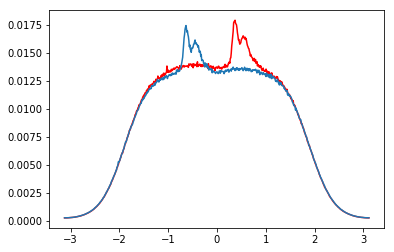

In [5]:
freqs = freq_array(divisor, nsamples = 640)
fig, ax = plt.subplots()
ax.plot(shift(freqs), shift(mean_powers_1230), color = 'red')
ax.plot(shift(freqs), shift(mean_powers_1231))
plt.show()

In [6]:
ROn_power = shift(mean_powers_1230)[320:]
ROff_power = shift(mean_powers_1231)[320:]

LOn_power = shift(mean_powers_1231)[:320]
LOff_power = shift(mean_powers_1230)[:320]

R_freqs = shift(freqs)[320:]
L_freqs = shift(freqs)[:320]

In [7]:
offline = np.concatenate((LOff_power, ROff_power))
online = np.concatenate((LOn_power, ROn_power))

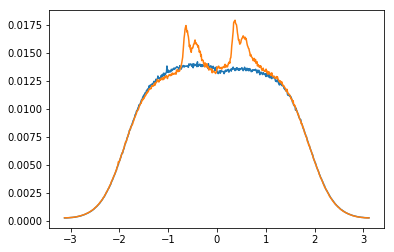

In [8]:
plt.plot(shift(freqs), offline)
plt.plot(shift(freqs), online)
plt.show()

In [9]:
shape = online / offline

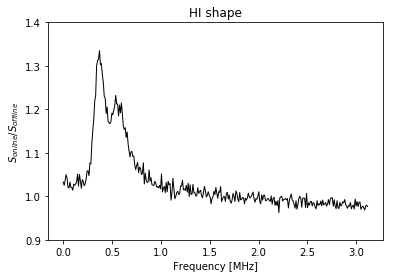

In [10]:
fig, ax = plt.subplots()
ax.plot(shift(freqs)[shift(freqs) >=0], shape[shift(freqs) >=0], color = 'black', linewidth = 1)
ax.set_ylim(0.9,1.4)
ax.set_xlabel(r'Frequency [MHz]')
ax.set_ylabel(r'$S_{online}/S_{offline}$')
ax.set_title('HI shape')
plt.show()

In [11]:
left_bound = 0.2
right_bound = 1

freq_range = shift(freqs)[shift(freqs) >=0]
shape_range = shape[shift(freqs) >=0]

xbase = np.concatenate((freq_range[freq_range < left_bound], freq_range[freq_range > right_bound]))
ybase = np.concatenate((shape_range[freq_range < left_bound], shape_range[freq_range > right_bound]))

In [12]:
params = np.polyfit(xbase, ybase, 2)
baseline_fit = np.polyval(params,freq_range)

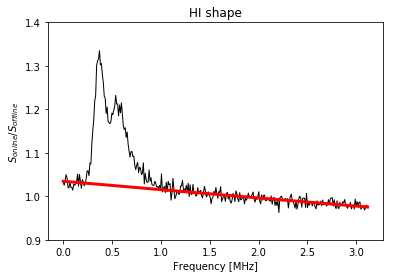

In [13]:


fig, ax = plt.subplots()
ax.plot(shift(freqs)[shift(freqs) >=0], shape[shift(freqs) >=0], color = 'black', linewidth = 1)
ax.plot(freq_range, baseline_fit, color = 'red', linewidth = 3)
ax.set_ylim(0.9,1.4)
ax.set_xlabel(r'Frequency [MHz]')
ax.set_ylabel(r'$S_{online}/S_{offline}$')
ax.set_title('HI shape')
# ax.set_xlim(0,1)
plt.show()

In [14]:
adjsuted_shape = shape[shift(freqs)>= 0 ] - baseline_fit

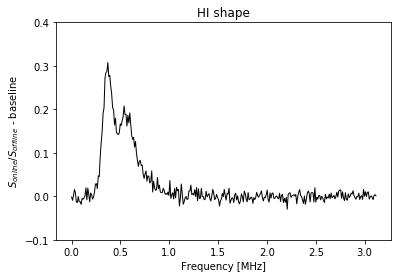

In [15]:
fig, ax = plt.subplots()
ax.plot(freq_range, adjsuted_shape, color = 'black', linewidth = 1)
# ax.set_ylim(0.9,1.4)
ax.set_xlabel(r'Frequency [MHz]')
ax.set_ylabel(r'$S_{online}/S_{offline}$ - baseline')
ax.set_title('HI shape')
ax.set_ylim(-0.1,0.4)

plt.show()

In [16]:
T_sys = 136.397932944

In [17]:
calibrated_adjusted_shape = adjsuted_shape * T_sys

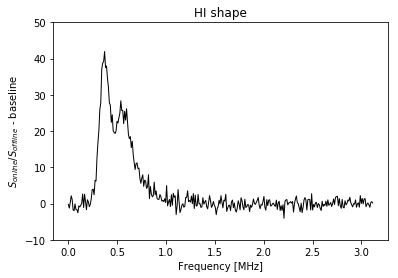

In [18]:
fig, ax = plt.subplots()
ax.plot(freq_range, calibrated_adjusted_shape, color = 'black', linewidth = 1)
ax.set_xlabel(r'Frequency [MHz]')
ax.set_ylabel(r'$S_{online}/S_{offline}$ - baseline')
ax.set_title('HI shape')
ax.set_ylim(-10,50)

plt.show()

In [19]:
f0 = 1420.4*u.MHz
f = 1420*u.MHz + shift(freqs)*u.MHz
deltaf = f0 - f
v = -c.c * deltaf / f0
v = (v.to(u.km / u.s)).value

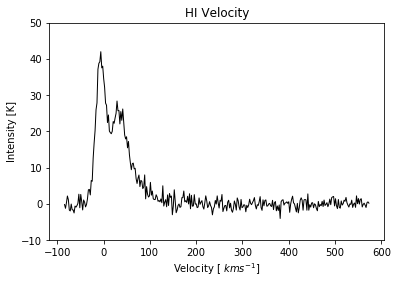

In [20]:
fig, ax = plt.subplots()
ax.plot(v[320:],calibrated_adjusted_shape, color = 'black', linewidth = 1)
ax.set_title('HI Velocity')
ax.set_ylabel('Intensity [K]')
ax.set_xlabel('Velocity [ $kms^{-1}$]')
ax.set_ylim(-10,50)


plt.show()

In [21]:
doppler_v_correction = -17.3751436155*(u.km / u.s)

In [22]:
corrected_v = v - doppler_v_correction.value

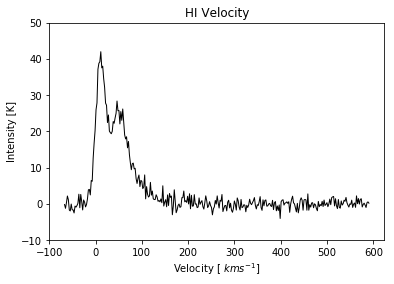

In [23]:
fig, ax = plt.subplots()
ax.plot(corrected_v[320:],calibrated_adjusted_shape, color = 'black', linewidth = 1)
ax.set_title('HI Velocity')
ax.set_ylabel('Intensity [K]')
ax.set_xlabel('Velocity [ $kms^{-1}$]')
ax.set_ylim(-10,50)


plt.show()

In [24]:
def peak_finder(signal):

    threshold = 28
    peaks = [] #x positions of the peaks, or rather, their index

    for i in range(2,len(signal)-2):

        if signal[i - 2] < signal[i] and signal[i - 1] < signal[i]and signal[i] > signal[i + 1] and signal[i] > signal[i + 2]: #four
                                    #conditions to be a peak (see description)
            if signal[i] > threshold: #is the value of the spectrum at i higher than our
                            #threshold?

                peaks.append(i)
    return peaks

In [25]:
peaks = peak_finder(calibrated_adjusted_shape)
print(peaks)

[38, 55]


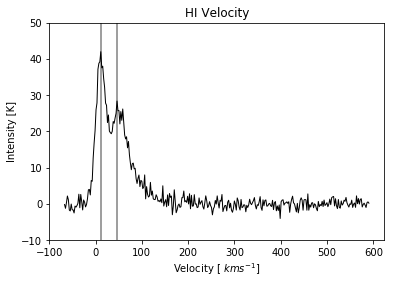

In [26]:
fig, ax = plt.subplots()
ax.plot(corrected_v[320:],calibrated_adjusted_shape, color = 'black', linewidth = 1)
ax.set_title('HI Velocity')
ax.set_ylabel('Intensity [K]')
ax.set_xlabel('Velocity [ $kms^{-1}$]')
ax.set_ylim(-10,50)
ax.axvline(corrected_v[320:][38], color = 'black', alpha = 0.5)
ax.axvline(corrected_v[320:][55], color = 'black', alpha = 0.5)

plt.show()

In [27]:
print(corrected_v[320:][38])
print(corrected_v[320:][55])

11.2741328164
46.3137218653


In [28]:
G_fit = {'amp': [ 37.26716193,   7.0412238 ,  20.01914257], 'avg': [ 10.395348  ,  72.40347405,  48.06774273], 'sig': [ 10.09137635,  35.40084108,  16.93684964]}

In [29]:
# Define Gaussian distribution (Normalized when A = 1)
def gaussian(x, mu, sigma,A):
    return A*np.exp(-((x-mu)**2/(2*sigma**2)))

In [30]:
v_range = corrected_v[320:]
G_1 = gaussian(v_range, G_fit['avg'][0],  G_fit['sig'][0], G_fit['amp'][0])
G_2 = gaussian(v_range, G_fit['avg'][1],  G_fit['sig'][1], G_fit['amp'][1])
G_3 = gaussian(v_range, G_fit['avg'][2],  G_fit['sig'][2], G_fit['amp'][2])
three_gaussian_fit = G_1 + G_2 + G_3

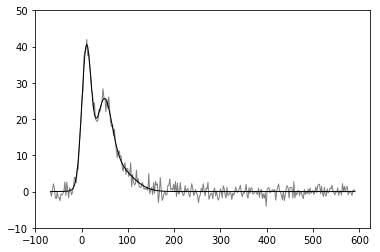

In [31]:
fig, ax = plt.subplots()
ax.plot(corrected_v[320:],calibrated_adjusted_shape, color = 'black', linewidth = 1, alpha = 0.5)
ax.plot(v_range,three_gaussian_fit, color = 'black', linewidth = 1)

ax.set_ylim(-10,50)

plt.show()

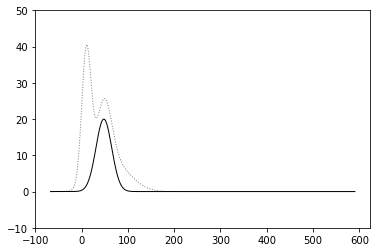

In [42]:
fig, ax = plt.subplots()
ax.plot(v_range,three_gaussian_fit, color = 'black', linewidth = 1, alpha = 0.5, ls = ":")
# ax.plot(v_range,G_1, color = 'black', linewidth = 1)
# ax.plot(v_range,G_2, color = 'black', linewidth = 1)
ax.plot(v_range,G_3, color = 'black', linewidth = 1)

ax.set_ylim(-10,50)

plt.show()

In [33]:
10.09137635,  35.40084108,  16.93684964

(10.09137635, 35.40084108, 16.93684964)

In [34]:
#avg
10.395348  ,  72.40347405,  48.06774273

(10.395348, 72.40347405, 48.06774273)

In [35]:
10.395348 + 10.09137635

20.486724350000003

In [36]:
72.40347405 + 35.40084108

107.80431512999999

In [37]:
48.06774273 + 16.93684964

65.00459237

In [38]:
10.395348 - 10.09137635

0.30397164999999937

In [39]:
72.40347405 - 35.40084108

37.00263297

In [40]:
48.06774273 - 16.93684964

31.13089309